In [1]:
import os
import argparse
import csv
import datetime
import glob
import math
import sys
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
from os.path import join

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle
from collections import Counter

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

import librosa
import kapre
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D

import matplotlib.pyplot as plt
%matplotlib inline 
import scikitplot as skplt

def generator(features, labels, batch_size):
    while True:
        batch_features = []
        batch_labels = []
        
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features.extend(features[index])
            batch_labels.extend(labels[index])
        batch_features = np.array(batch_features)
        batch_labels = np.array(batch_labels)
        yield batch_features, batch_labels    

Using TensorFlow backend.


In [ ]:
AUDIO_PATH = '../genres/'
classes_temp = os.walk(AUDIO_PATH).__next__()[1] ## Finds the number of classes

In [ ]:
load = True
split_num = 80 ## Number of songs on train per class
savename = "offseti2-duration2.npy"

if load:    
    list_data_train = np.load("list_data_train-" + savename)
    classes_train = np.load("classes_train-" + savename)
    list_data_test = np.load("list_data_test-" + savename)
    classes_test = np.load("classes_test-" + savename)
    
else:
    list_data = [] 
    classes = []
    for c in tqdm(classes_temp):
        for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
            for file in files[:split_num]:
                for i in range(0, 20, 2):
                    filepath = os.path.join(root, file)    
                    wavedata, samplerate = librosa.load(filepath, mono=True, offset=i, duration=2)    
                    wavedata = wavedata[np.newaxis, :]
                    list_data.append(wavedata)
                    classes.append(c)

    np.save("list_data_train-" + savename, list_data)
    np.save("classes_train-" + savename, classes)
    
    list_data = [] 
    classes = []
    for c in tqdm(classes_temp):
        for root, subdirs, files in os.walk(os.path.join(AUDIO_PATH, c)):
            for file in files[split_num:]:
                for i in range(0, 20, 2):
                    filepath = os.path.join(root, file)    
                    wavedata, samplerate = librosa.load(filepath, mono=True, offset=i, duration=2)    
                    wavedata = wavedata[np.newaxis, :]
                    list_data.append(wavedata)
                    classes.append(c)

    np.save("list_data_test-" + savename, list_data)
    np.save("classes_test-" + savename, classes)

In [ ]:
print('Train Shape',list_data_train.shape)
print('Test Shape',list_data_test.shape)

In [ ]:
labelencoder = LabelEncoder()
labelencoder.fit(classes_train)
n_classes = len(labelencoder.classes_)
print(n_classes, "classes:", ", ".join(list(labelencoder.classes_)))
classes_num_train = labelencoder.transform(classes_train)
classes_num_test = labelencoder.transform(classes_test)

In [ ]:
classes_num_1hot = to_categorical(classes_num_train)
print('Train classes shape:',classes_num_1hot.shape)

In [ ]:
# testset_size = 0.25
# splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
# splits = splitter.split(data, classes_num)

In [ ]:
# for train_index, test_index in splits:
#     print("TRAIN INDEX:", train_index)
#     print("TEST INDEX:", test_index)
    
#     train_set = data[train_index]
#     test_set = data[test_index]
    
#     train_classes = classes_num[train_index]
#     train_classes_1hot = classes_num_1hot[train_index]
#     test_classes = classes_num[test_index]

# print(train_set.shape)
# print(test_set.shape)

In [ ]:
list_data_train, classes_num_1hot  = shuffle(list_data_train, classes_num_1hot, random_state=0)
list_data_test, classes_num_test  = shuffle(list_data_test, classes_num_test, random_state=0)

print(list_data_train.shape)
print(list_data_test.shape)

In [ ]:
cnt = Counter(classes_num_train)
print("Number of files in each category in TRAIN set:")
for k in sorted(cnt.keys()):
    print(k, ":", cnt[k])

In [ ]:
input_shape = list_data_train.shape[1:]  
input_shape

In [9]:
datagen = ImageDataGenerator(
    samplewise_std_normalization=True)

train_generator = datagen.flow_from_directory(
        '../scalogram_genres/train/',
        batch_size=8,
        color_mode = 'grayscale',
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        '../scalogram_genres/validation/',
        batch_size=8,
        color_mode = 'grayscale',
        class_mode='categorical')

/home/vishwasnm/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:355: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 900 images belonging to 10 classes.
Found 100 images belonging to 10 classes.


In [17]:
input_shape = (256,256,1)

In [18]:
np.random.seed(0)
loadModel = None
loadModel = False
modelName = "model1-conv1d"

if loadModel:
    model = keras.models.load_model(modelName + ".h5", custom_objects={'Melspectrogram':kapre.time_frequency.Melspectrogram, 
                                                                       'Normalization2D': kapre.utils.Normalization2D})
    history = np.load(modelName + "-history.npy").item()
else:
    model = Sequential()
#     model.add(Melspectrogram(n_dft=1024, n_hop=512, input_shape=input_shape, return_decibel_melgram=True, trainable_fb=False, name='melgram'))
#     model.add(Normalization2D(str_axis='freq'))
    model.add(Reshape((-1, 1) ,input_shape = input_shape))
    
    # Layer 1
    model.add(Conv1D(32, 8, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4)) 

    # Layer 2
    model.add(Conv1D(32, 8, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=4)) 
    model.add(Flatten()) 

    model.add(Dense(100, activation='relu')) 
    model.add(BatchNormalization())
    model.add(Dense(10,activation='softmax'))
    
    model.compile(loss='categorical_crossentropy' , optimizer='sgd' , metrics=['accuracy'])

    history = None
    
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 65536, 1)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 65529, 32)         288       
_________________________________________________________________
batch_normalization_8 (Batch (None, 65529, 32)         128       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 16382, 32)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 16375, 32)         8224      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16375, 32)         128       
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 4093, 32)         

In [19]:
History = model.fit_generator(train_generator, validation_data=validation_generator, epochs=10)

Epoch 1/10
113/113 [==============================] - 10s 86ms/step - loss: 2.0836 - accuracy: 0.2789 - val_loss: 4.0779 - val_accuracy: 0.0700
Epoch 2/10
113/113 [==============================] - 9s 80ms/step - loss: 1.8047 - accuracy: 0.3911 - val_loss: 3.0831 - val_accuracy: 0.1900
Epoch 3/10
113/113 [==============================] - 9s 80ms/step - loss: 1.3917 - accuracy: 0.5578 - val_loss: 3.5243 - val_accuracy: 0.3200
Epoch 4/10
113/113 [==============================] - 9s 81ms/step - loss: 1.0860 - accuracy: 0.6756 - val_loss: 1.8536 - val_accuracy: 0.3200
Epoch 5/10
113/113 [==============================] - 9s 81ms/step - loss: 0.8553 - accuracy: 0.7622 - val_loss: 2.1411 - val_accuracy: 0.4000
Epoch 6/10
113/113 [==============================] - 9s 81ms/step - loss: 0.4958 - accuracy: 0.8856 - val_loss: 2.8160 - val_accuracy: 0.4200
Epoch 7/10
113/113 [==============================] - 9s 81ms/step - loss: 0.3428 - accuracy: 0.9356 - val_loss: 2.5029 - val_accuracy: 0.400

In [ ]:
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='auto')
History = model.fit(list_data_train, classes_num_1hot, validation_split=0.1, batch_size=32, epochs=15)

if history is None:
    history = History.history
else:
    for key in History.history.keys():
        history[key].extend(History.history[key])
        
model.save(modelName + ".h5")
np.save(modelName + "-history.npy", history)

In [20]:
def plot_traincurve(history):
    colors = {'loss':'r', 'accuracy':'b', 'val_loss':'m', 'val_accuracy':'g'}
    plt.figure(figsize=(10,6))
    plt.title("Training Curve") 
    plt.xlabel("Epoch")
    for measure in history.keys():
        color = colors[measure]
        ln = len(history[measure])
        plt.plot(range(1,ln+1), history[measure], color + '-', label=measure)  # use last 2 values to draw line
    plt.legend(loc='upper left', scatterpoints = 1, frameon=False)

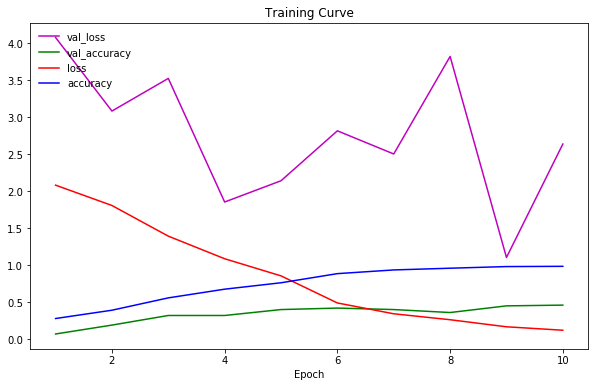

In [21]:
history = History.history
plot_traincurve(history)

In [ ]:
test_pred = model.predict_classes(list_data_test, verbose=1)
test_proba = model.predict_proba(list_data_test, verbose=1)

In [ ]:
accuracy_score(classes_num_test, test_pred)

In [ ]:
skplt.metrics.plot_confusion_matrix(classes_num_test, test_pred, normalize=True)
plt.show()

In [ ]:
skplt.metrics.plot_precision_recall(classes_num_test, test_proba)
plt.show()

In [ ]:
skplt.metrics.plot_roc(classes_num_test, test_proba)
plt.show()